This is a demonstration of how to capture frames from training videos and feed into the Pretrained Inception-V3 to extract 2048 dimensional feature vector. This is just the preprocessing step and is done only on one training video. One may increase the training size for better performance.

**Note**: Enable internet on kernel settings to download the weights for Inception-V3

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [2]:
# Importing the required libraries

import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import pickle
import shutil
import time
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
import keras
print('Keras version:', keras.__version__)
print('OpenCV version:', cv2.__version__)

Keras version: 2.3.1
OpenCV version: 4.1.2


In [4]:
# Initializing the paths

input_path = '/kaggle/input/deepfake-detection-challenge/'
output_path = '/kaggle/working/'
train_dir = glob.glob(input_path + 'train_sample_videos/*.mp4')
test_dir = glob.glob(input_path + 'test_videos/*.mp4')

In [5]:
# Considering just first video
train_dir = [train_dir[0]]
train_dir

['/kaggle/input/deepfake-detection-challenge/train_sample_videos/drsakwyvqv.mp4']

In [6]:
# Reading the labels of training data

df_train = pd.read_json(input_path + 'train_sample_videos/metadata.json').transpose()
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


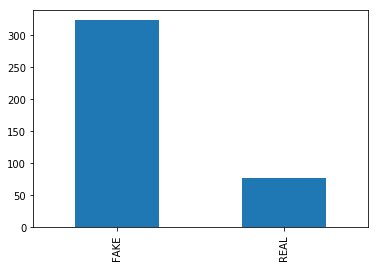

In [7]:
# Plotting the count of labels

# Fake class is in majority
df_train.label.value_counts().plot.bar()

In [8]:
# Creating the directory which would contain the video frames

# shutil.rmtree(output_path + 'train_frames')
os.mkdir(output_path + 'train_frames')

In [9]:
# Creating frames of the videos

t = time.time()
# count1 = 0
for v in train_dir:
    t1 = time.time()
    v_name = v.split("/")[-1]
    if not os.path.exists(output_path + "train_frames/" + v_name.split(".")[0]):
        os.mkdir(output_path + "train_frames/" + v_name.split(".")[0])
    count = 0
    cap = cv2.VideoCapture(v)
    while count < 100:
        cap.set(cv2.CAP_PROP_POS_MSEC,(count * 100))   
        ret, frame = cap.read()
        imagex = frame
        cv2.imwrite("train_frames/" + v_name.split(".")[0] + "/frame" + str(count) + ".jpg", imagex)
        count = count + 1
#     count1 += 1
#     print('Elapsed: ', time.time() - t1, ' | ', count1, '/', len(train_dir), ' | ', v)
print('Total elapsed: ', time.time() - t)

Total elapsed:  64.01999163627625


In [10]:
# Taking the base model as Inception V3 and initializing it's weight with imagenet

# Enable internet on kernel settings
input_tensor = Input(shape = (229, 229, 3))
cnn_model = InceptionV3(input_tensor = input_tensor, weights = 'imagenet', include_top = False, pooling = 'avg')
cnn_model.summary()

87916544/87910968 [==============================] - 8s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 114, 114, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 114, 114, 32) 0           batch_normalization_1[0][0]      
______________________

In [11]:
# Defining the frame files

frame_files = []
for x in range(0, 100):
    frame_files.append(glob.glob('train_frames/*/frame' + str(x) + '.jpg')[0])
print('Total frames captured: ', len(frame_files))

Total frames captured:  100


In [12]:
frame_files

['train_frames/drsakwyvqv/frame0.jpg',
 'train_frames/drsakwyvqv/frame1.jpg',
 'train_frames/drsakwyvqv/frame2.jpg',
 'train_frames/drsakwyvqv/frame3.jpg',
 'train_frames/drsakwyvqv/frame4.jpg',
 'train_frames/drsakwyvqv/frame5.jpg',
 'train_frames/drsakwyvqv/frame6.jpg',
 'train_frames/drsakwyvqv/frame7.jpg',
 'train_frames/drsakwyvqv/frame8.jpg',
 'train_frames/drsakwyvqv/frame9.jpg',
 'train_frames/drsakwyvqv/frame10.jpg',
 'train_frames/drsakwyvqv/frame11.jpg',
 'train_frames/drsakwyvqv/frame12.jpg',
 'train_frames/drsakwyvqv/frame13.jpg',
 'train_frames/drsakwyvqv/frame14.jpg',
 'train_frames/drsakwyvqv/frame15.jpg',
 'train_frames/drsakwyvqv/frame16.jpg',
 'train_frames/drsakwyvqv/frame17.jpg',
 'train_frames/drsakwyvqv/frame18.jpg',
 'train_frames/drsakwyvqv/frame19.jpg',
 'train_frames/drsakwyvqv/frame20.jpg',
 'train_frames/drsakwyvqv/frame21.jpg',
 'train_frames/drsakwyvqv/frame22.jpg',
 'train_frames/drsakwyvqv/frame23.jpg',
 'train_frames/drsakwyvqv/frame24.jpg',
 'train_fr

In [13]:
# Extracting features for each captured frame

cnn_output = {}
t = time.time()
for name in frame_files:
    t1 = time.time()
    img = image.load_img(name, target_size = (229, 229, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    folder_name = name.split("/")[1]
    if folder_name not in cnn_output.keys():
        cnn_output[folder_name] = []
    result = cnn_model.predict(x)
    cnn_output[folder_name].append(result)
print('Elapsed: ', time.time() - t)

Elapsed:  16.01075839996338


In [14]:
# Example of CNN output for one video

cnn_output[frame_files[0].split('/')[1]]

[array([[0.30943778, 0.30200014, 0.9675778 , ..., 0.0127911 , 0.307152  ,
         0.79485726]], dtype=float32),
 array([[0.26071313, 0.29687062, 0.98487884, ..., 0.00358828, 0.38605717,
         0.9673968 ]], dtype=float32),
 array([[0.27860436, 0.23035488, 0.9585996 , ..., 0.00988513, 0.32207137,
         0.8800188 ]], dtype=float32),
 array([[0.31841514, 0.2757662 , 1.0996891 , ..., 0.        , 0.24393243,
         0.90934354]], dtype=float32),
 array([[0.38881865, 0.38635525, 1.030648  , ..., 0.09852608, 0.39619386,
         1.0635177 ]], dtype=float32),
 array([[0.38727668, 0.35579857, 0.8698095 , ..., 0.        , 0.22733893,
         1.3392087 ]], dtype=float32),
 array([[0.71718895, 0.31324515, 1.228164  , ..., 0.0026452 , 0.3472741 ,
         1.0071164 ]], dtype=float32),
 array([[0.59365445, 0.30331546, 1.2798218 , ..., 0.00578025, 0.48711377,
         0.8865762 ]], dtype=float32),
 array([[0.4262567 , 0.35654587, 1.1077496 , ..., 0.11944942, 0.52035517,
         0.86025536]],

In [15]:
# Saving the cnn_output

os.mknod(output_path + 'cnn_output.txt')
with open('cnn_output.txt', 'wb') as f:
    pickle.dump(cnn_output, f)

In [16]:
# # Retrieving the cnn_output

# with open(output_path + 'cnn_output.txt', 'rb') as f:
#     cnn_output = pickle.load(f)

In [17]:
OUTPUT_ZIP = 'output.zip'
!7z a -bd -mmt4 $OUTPUT_ZIP $kaggle/working/train_frames


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
2 folders, 102 files, 32740501 bytes (32 MiB)

Creating archive: /working/train_frames.7z

Items to compress: 104


Files read from disk: 102
Archive size: 31553946 bytes (31 MiB)
Everything is Ok


In [18]:
shutil.rmtree(output_path + 'train_frames')